### Machine Learning

- Maria Zazpe Quintana

- Alba Rodríguez Berenguel

En este notebook vamos a realizar un modelo Decision Tree. Los pasos que vamos a seguir son:

1. Importación de librerías, funciones y datos.
2. Creación del modelo.
3. Entrenamiento del modelo.
4. Predicciones y evaluación.
5. Exportación del modelo.

## 1. Importación de librerías, funciones y datos.

In [1]:
# Load libraries.
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, fbeta_score, plot_confusion_matrix
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, classification_report
import scikitplot as skplt
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.inspection import PartialDependenceDisplay
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Function to evaluate the model.
def evaluate_model(ytest, ypred, ypred_proba = None):
    if ypred_proba is not None:
        print('ROC-AUC score of the model: {}'.format(roc_auc_score(ytest, ypred_proba[:, 1])))
    print('Accuracy of the model: {}\n'.format(accuracy_score(ytest, ypred)))
    print('Classification report: \n{}\n'.format(classification_report(ytest, ypred)))

In [3]:
# Load data.
X_train_val = pd.read_csv("../data/processed/X_train_val.csv",index_col=0 )
y_train_val = pd.read_csv("../data/processed/y_train_val.csv",index_col=0 )

x_val = pd.read_csv("../data/processed/X_val.csv",index_col=0 )
y_val = pd.read_csv("../data/processed/y_val.csv",index_col=0 )

## 2. Creación del modelo.

In [4]:
# Import the preprocessor.
preprocessor = pickle.load(open('../models/preprocessor.pickle', 'rb'))

#classifier
classifier = XGBClassifier(n_jobs = -1, random_state = 12345)

In [5]:
xgb_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

## 3. Entrenamiento del modelo.

In [6]:
xgb_model.fit(X_train_val, y_train_val)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['delivery',
                                                   'outdoor_seating',
                                                   'credit_cards',
                                                   'bike_parking',
                                                   'price_range', 'take_out',
                                                   'wifi', 'alcohol', 'caters',
                                                   'wheelchair_accessible',
                                                   'good_fo...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=-1, num_parallel_tree=None,
                               predictor=None, random_state=12345, ...))])

## 4. Predicciones y evalución.

In [7]:
# Predictions of target value for the validation set.
pred = xgb_model.predict(x_val)

# Predictions of probabilities of the target value for the validation set.
pred_proba = xgb_model.predict_proba(x_val)

### Precision, Recall, F1 y accuracy.

In [8]:
evaluate_model(y_val, pred)

Accuracy of the model: 0.7400902601945113

Classification report: 
              precision    recall  f1-score   support

           0       0.62      0.18      0.28     45127
           1       0.75      0.96      0.84    116406

    accuracy                           0.74    161533
   macro avg       0.68      0.57      0.56    161533
weighted avg       0.71      0.74      0.69    161533




- **Support** nos dice los datos reales que tenemos, 43264 que son 0 y 110766 que son 1.


- La **precisión** se calcula con las columnas de la matriz de confusión y su precisión es 0.62 para los casos 0 y 0.75 para los casos 1. Es similar, pero identifica mejor los 1, puntuaciones altas.


- El **recall** se calculas con las filas de la matriz de confusión, en este caso la predicción no es buena porque solo identifica el 0.18 de casos 0, aunque los casos 1 los predice correctamente en su mayoría (0.96).


- El **f1** es la combinación de estas dos métricas y nos indica que identifica el 0.84 de casos 1 y 0.29 de casos 0.


- El **accuracy** se calcula con la matriz de confusión, teniendo en cuenta los aciertos y es 0.74, es decir, que el modelo predice correctamente el 74% de los casos.

### Matriz de confusión.

Confusion matrix, without normalization
[[  8294  36833]
 [  5151 111255]]
Normalized confusion matrix
[[0.18379241 0.81620759]
 [0.0442503  0.9557497 ]]


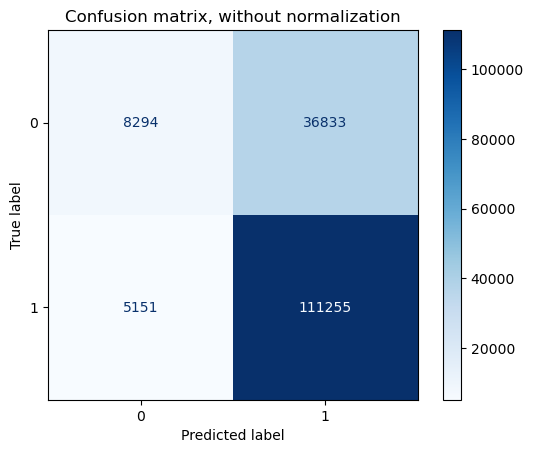

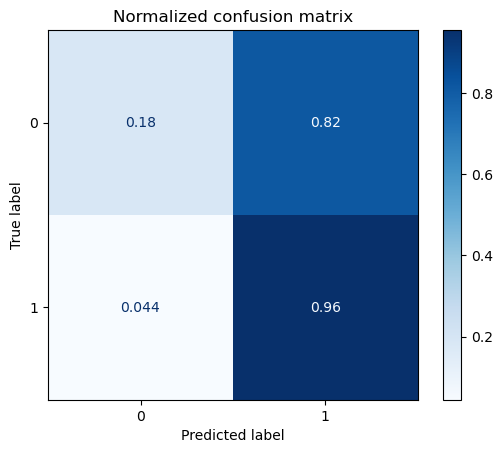

In [9]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

# Plot the confusion matrix
for title, normalize in titles_options:
    disp = plot_confusion_matrix(xgb_model, x_val, y_val,
                                 # display_labels=ytest,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)

plt.show()

La matriz muestra como el modelo predice correctamente la mayoría de puntuaciones altas, ya que acierta 106050 (0.96) y solo falla 4716 (0.043). Para los 0 no ocurre lo mismo, el modelo falla más ya que clasifica 35437 erroneamente (0.82) y solo acierta 7827 (0.18).

### Curva ROC.

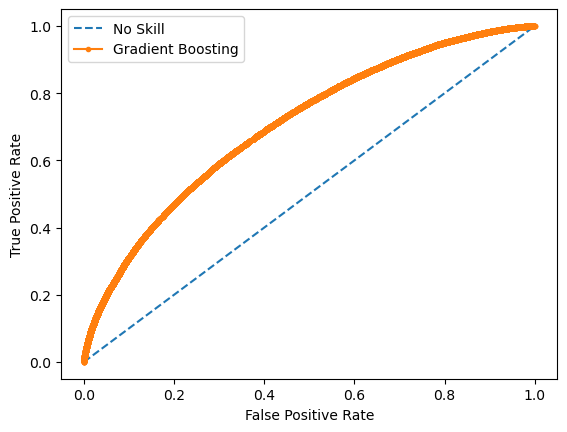

In [10]:
# Keep probabilities for the positive outcome only
yhat = pred_proba[:, 1]
# Calculate roc curves
fpr, tpr, thresholds = roc_curve(y_val, yhat)
# Plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Gradient Boosting')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# Show the plot
plt.show()

La clave de la curva ROC es que cuanto más cerca esté de la esquina superior izquierda de nuestro gráfico y cuanta más área haya debajo de la curva, mejor será el modelo. En este caso se aprecia que la curva está por encima de la línea de puntos, el área debajo de la curva está en torno al 70%.

### Curva Lift.

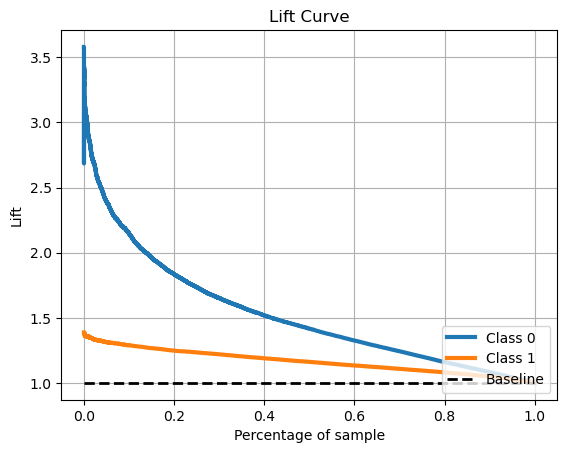

In [11]:
skplt.metrics.plot_lift_curve(y_val, pred_proba)
plt.show()

La curva de la clase 1 es la que realmente nos interesa, se encuentra por encima de la línea de puntos por lo que ya podemos confirmar que el modelo es mejor que la aletoriedad.

### Curva de ganancia.

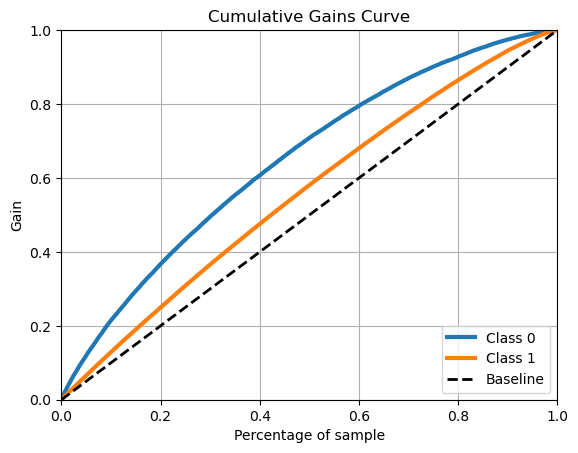

In [12]:
skplt.metrics.plot_cumulative_gain(y_val, pred_proba)
plt.show()

La ganancia de la clase 0 es superior a la de la clase 1, tomando por ejemplo el 20% de la muestra, se detectaría sobre el 25% de la clase 1 y cerca del 40% de la clase 0. Esta probabilidad aumenta a media que se incrementa el tamaño de la muestra.

## 5. Exportación del modelo.

In [13]:
#We save the model
with open('../models/xgboost.pickle', 'wb') as f:
    pickle.dump(xgb_model, f)

In [14]:
# To avoid the fit again.
with open('../models/xgboost.pickle', 'rb') as f:
    xgb_model = pickle.load(f)